In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from tqdm import tqdm_notebook as tqdm

In [2]:
def calculateRadius(points,thresh=0.7):
    
    alpha=points[2]-points[0]
    beta=points[3]-points[1]
    

    disc=alpha*beta*(1-thresh)
    disc/=alpha+beta
    disc=np.sqrt(disc)
    disc=np.floor(disc)
    disc=disc.astype(np.int32)
    
    return disc

In [3]:
data=pd.read_csv('training_set.csv')
data=data.set_index('image_name')
data=data[['x1','y1','x2','y2']]
data['x1']=data['x1']*480/640
data['x2']=data['x2']*480/640


In [4]:
def create_mask(img_size,points,mode='top_left',varience=1.5,normalized=True):
    """
    return normalized mask uint8 range 255
    shape [img_size[0],img_size[1]]
    """
    mask=np.zeros((img_size[0],img_size[1]))
    radius=calculateRadius(points)
    sigma=varience*radius
    sigma*=sigma
    sigma=2*sigma
    if mode=='top_left':
        try:
            cv2.circle(mask,(int(points[0]),int(points[1])),radius, (1), -1)
        except:
            mask[int(points[0]),int(points[1])]=1
            if not normalized:
                mask=mask*255
            print("An error in cv.circle")
        s=np.array(np.meshgrid(np.arange(img_size[0]),np.arange(img_size[0]))).transpose([1,2,0]).reshape(-1,2).astype(np.float32)
        origin=np.floor(np.array([points[0],points[1]]))
    
    elif mode=='bottom_right':
        try:
            cv2.circle(mask,(int(points[2]),int(points[3])),radius, (1), -1)
        except:
            mask[int(points[2]),int(points[3])]=1
            if not normalized:
                mask=mask*255
            print("An error in cv.circle")
        s=np.array(np.meshgrid(np.arange(img_size[0]),np.arange(img_size[0]))).transpose([1,2,0]).reshape(-1,2).astype(np.float32)
        origin=np.floor(np.array([points[2],points[3]]))
    else:
        print("Mode error")
        return
        
    s-=origin
    s=np.square(s)
    s=np.sum(s,axis=1)
    s/=sigma
    s=np.exp(-s)
    s=s.reshape(img_size)
#     s=s/np.max(s)
    if not normalized:
        s=s*255
    
    return s

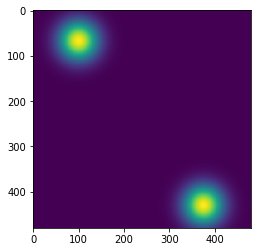

In [10]:
points=np.array(data.loc['JPEG_20160607_153530_1000669241198.png']).astype(np.float32)
varience=5
mask_top=create_mask((480,480),points,mode='bottom_right',varience=varience)
mask_bottom=create_mask((480,480),points,mode='top_left',varience=varience)
mask=mask_top+mask_bottom
plt.imshow(mask)
# plt.imshow(img)
# plt.plot(points[0],points[1],'bo')
# plt.plot(points[2],points[3],'bo')
plt.show()

## loss

In [ ]:
def focal_loss(preds,truth):
    """
    [?,h,w,1]
    """
    preds=tf.squeeze(preds,axis=-1)
    truth=tf.squeeze(truth,axis=-1)
    
    exact_mask=tf.equal(truth,tf.ones_like(truth))
    others_mask=tf.logical_not(exact_mask)
    
    positive_preds=tf.boolean_mask(preds,mask=exact_mask)
    negative_preds=tf.boolean_mask(preds,mask=others_mask)
    return negative_preds
    

## Predictions from heat map

In [146]:
points=np.array(data.loc['JPEG_20160607_153530_1000669241198.png']).astype(np.float32)
mask_top=create_mask((480,480),points,mode='bottom_right')
mask_bottom=create_mask((480,480),points,mode='top_left')
mask_top=np.expand_dims(mask_top,axis=0)
mask_bottom=np.expand_dims(mask_bottom,axis=0)
mask_bottom.shape
heatmaps=np.concatenate([mask_top,mask_bottom])
heatmaps.shape

(2, 480, 480)

In [15]:
sess=tf.Session()

In [65]:
idx=np.argmax(mask)
ridx=int(idx/480)
cidx=idx%480
mask[ridx,cidx]
print(idx)
print(ridx)
print(cidx)

32260
67
100


In [152]:
def get_predictions_from_heatmap(heatmap,img_size):
    """
    heatmap=[?,h,w]
    return preds =[?,2]
    """
    mask=tf.contrib.layers.flatten(heatmap)
    idx=tf.argmax(mask,axis=1)
    ridx=tf.math.floor(idx/img_size[1])
    cidx=tf.mod(idx,img_size[0])
    ridx=tf.cast(ridx,tf.int32)
    cidx=tf.cast(cidx,tf.int32)

    preds=tf.stack([ridx,cidx],axis=1)
    return preds

In [156]:
mask1=tf.convert_to_tensor(mask)
mask1=tf.reshape(mask1,[1,480,480])
preds=get_predictions_from_heatmap(heatmaps,(480,480))
preds=sess.run(preds)

Tensor("ArgMax_64:0", shape=(2,), dtype=int64)
Tensor("Cast_44:0", shape=(2,), dtype=int32)


In [166]:
heatmaps[0][429,375]

1.0

In [167]:
preds[0,:]

array([429, 375], dtype=int32)

#### preds works

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


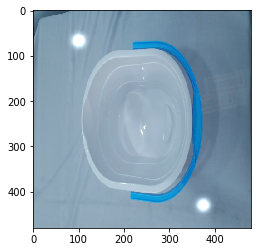

In [53]:
img=cv2.imread('JPEG_20160607_153530_1000669241198.png')
img=cv2.resize(img,(480,480))
img=img/255
img=img+np.expand_dims(mask,axis=-1)
plt.imshow(img)

In [60]:
cv2.imwrite('1.png',mask*255)

True

Label saving

In [55]:
import pickle
import os

In [95]:
filenames=[]
f=open('train_list.txt','w')
for x,_ in data.iterrows():
    filenames.append(x)
    f.write(x)
    f.write('\n')
f.close()
print(len(filenames))

24000


In [97]:
label_dict={}
for file in filenames:
    points=np.array(data.loc[file])
    points=np.floor(points)
    label_dict[file]=points
print("completed")

with open('labels_xy.pickle','wb') as handle:
    pickle.dump(label_dict,handle,protocol=pickle.HIGHEST_PROTOCOL)
print("saved")

completed
saved


In [98]:
left_path='./labels/left'
right_path='./labels/right'
with open('labels_xy.pickle', 'rb') as handle:
    labels_xy = pickle.load(handle)

In [100]:
# img_size=(480,480)
# for file in tqdm(filenames):
#     try:
#         lsv=os.path.join(left_path,file)
#         rsv=os.path.join(right_path,file)
#         points=labels_xy[file]
#         varience=1.5
#         left_mask=create_mask(img_size,points,mode='top_left',varience=varience,normalized=False)
#         right_mask=create_mask(img_size,points,mode='bottom_right',varience=varience,normalized=False)
#         cv2.imwrite(lsv,left_mask)
#         cv2.imwrite(rsv,right_mask)
#     except:
#         print("Error in {} ".format(file))
# print("Completed")

/home/aghinsa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


An error in cv.circle
An error in cv.circle
Error in 1477035945016DSC_7534.png 
Completed


In [101]:
labels_xy['1477035945016DSC_7534.png']

array([ 251., 3955.,  251., 3955.])

In [102]:
data.loc['1477035945016DSC_7534.png']

x1     251.25
y1    3955.00
x2     251.25
y2    3955.00
Name: 1477035945016DSC_7534.png, dtype: float64

Remove 1477035945016DSC_7534.png from train_list